In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
file_path = "cleaned_coin_Bitcoin.csv" 
df = pd.read_csv(file_path)

In [3]:
# 1. Normalize the data for LSTM (scaling it between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

In [4]:
# 2. Function to create dataset for LSTM with a given time_step
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Features (previous 'time_step' values)
        y.append(data[i + time_step, 0])  # Target (next value, i.e., the future close price)
    return np.array(X), np.array(y)


In [5]:
# 3. Create dataset using 60 time steps (past 60 days to predict the next day's closing price)
time_step = 60
X, y = create_dataset(scaled_data, time_step)


In [6]:
# 4. Reshape X to be 3D (samples, time_steps, features) as required by LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)  # Add 1 for the feature dimension


In [7]:
# 5. Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(1038, 60, 1), y_train=(1038,)
Testing data shape: X_test=(260, 60, 1), y_test=(260,)


In [8]:
# 6. Build the LSTM model
model = Sequential()

In [9]:
# Add LSTM layers
from tensorflow.keras.layers import Input

model.add(Input(shape=(X_train.shape[1], 1))) 
# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization for no overfitting
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer (final one)
model.add(Dropout(0.2))  # Dropout for regularization

# Output layer
model.add(Dense(units=1))  # Predict the next 'Close' value



In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0029 - val_loss: 0.0211
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.2219e-04 - val_loss: 0.0095
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 2.5267e-04 - val_loss: 0.0081
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.5741e-04 - val_loss: 0.0082
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 2.6513e-04 - val_loss: 0.0113
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 2.0586e-04 - val_loss: 0.0101
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 1.9282e-04 - val_loss: 0.0059
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.9219e-04 - val_loss: 0.0118
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.9298e-04 - val_loss: 0.0117
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 1.9471e-04 - val_loss: 0.0112


In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.08411700483699235
Mean Squared Error (MSE): 0.011185363278488616
Root Mean Squared Error (RMSE): 0.1057608778258228
R-squared (R²): 0.8228529744142522


In [14]:
# Save the model in the native Keras format
model.save('bitcoin_lstm_model.keras')

print("Model saved in the native Keras format")


Model saved in the native Keras format


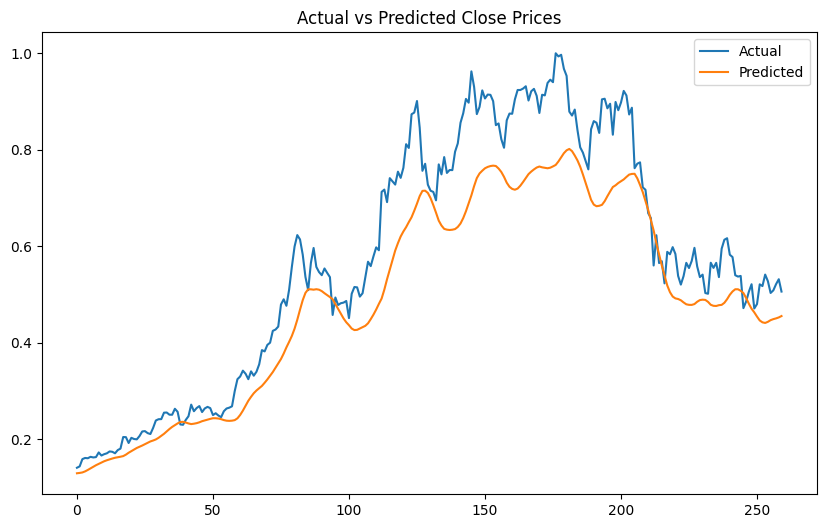

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.show()